# Recovering Gray Codes

## Packages

In [1]:
try:
    import os

    from google.colab import drive
    drive.mount('/content/gdrive')

    os.chdir( '/content/gdrive/My Drive/Colab Notebooks/GoA/02_binary/' )
    !ls
except Exception:
    pass

In [60]:
from tensorflow.keras.layers import Dense, Input, BatchNormalization
from tensorflow.keras.layers import Conv2D, Flatten, Lambda
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.losses import mse, binary_crossentropy, categorical_crossentropy
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.keras.models import model_from_json

import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist # For calculating QPSK decoding

import datetime, itertools, dill

## VAE Module

In [131]:
class CommVAEBinary(object):
  def __init__(self, in_dim=None, latent_dim=None, h_dim=None, obj_fn = 'RBF', n0=1.0):
    self.in_dim = in_dim
    self.latent_dim = latent_dim
    self.n0 = n0
    self.h_dim = h_dim
    self.obj_fn = obj_fn

    
    
    if self.in_dim and self.latent_dim:
      self.make_model()
    
  def make_model(self):
    # Input layer
    self.inputs = Input(shape=(self.in_dim,), name="enc_in")
    
    # Hidden Layers
    x = self.inputs
    if self.h_dim is not None:
      for (i,d) in enumerate(self.h_dim):
        x = Dense( d, activation='relu', name="enc_l{}".format(i))(x)
    # Mean and Variance
    self.z_mean = Dense(self.latent_dim, name="z_mean")(x)
    
    # Channel
    self.z = Lambda(self.channel, output_shape=(self.latent_dim,), name="z")(self.z_mean)
    
    # Encoder model
    self.encoder = Model(self.inputs, [self.z_mean,self.z], name="encoder")
    
    # Decoder
    self.latent_inputs = Input(shape=(self.latent_dim,), name="z_sample")
    
    # Hidden layers
    x = self.latent_inputs
    if self.h_dim is not None:
      for (i,d) in enumerate(self.h_dim[::-1]):
        x = Dense( d, activation='relu', name="dec_l{}".format(i))(x)
    self.dec_outputs = Dense( self.in_dim, activation='sigmoid', name="decoder_out")(x)
    
    # Decoder model
    self.decoder = Model(self.latent_inputs, self.dec_outputs, name="decoder")
    
    # VAE
    self.outputs = self.decoder(self.encoder(self.inputs)[1])
    self.model = Model(self.inputs, self.outputs, name="VAE")
    
    # Losses
    self.recon_loss = binary_crossentropy(self.inputs, self.outputs)
    self.recon_loss *= self.in_dim # Because binary_crossentropy divides by N


    if self.obj_fn == 'AWGN':
      # print( "Model with AWGN ")
      sig_pow = 0.5/5.0 * K.sum(K.square(self.z_mean), axis=-1) 
      noise_term = 0.5 * self.latent_dim * (self.n0/self.latent_dim - 1.0 - K.log(self.n0/self.latent_dim))
      self.kl_loss = sig_pow + noise_term
    elif self.obj_fn == 'RBF':
      # print( "Model with RBF")
      sig_pow = 0.5 * K.sum(K.square(self.z_mean), axis=-1) 
      noise_term = 0.5 * self.latent_dim * (self.n0/self.latent_dim - 1.0 - K.log(self.n0/self.latent_dim))
      rbf_term = K.log(1.0 + 0.5*self.latent_dim/self.n0 * sig_pow)
      self.kl_loss = sig_pow + noise_term - rbf_term
    else:
      raise NotImplementedError("Unknown obj_fn: {}".format(self.obj_fn))
    
    
    self.vae_loss = K.mean( self.recon_loss + self.kl_loss )

    self.model.add_loss( self.vae_loss )
    
    self.model.compile( optimizer = 'adam' )
#     self.model.compile( optimizer=tf.train.AdamOptimizer(learning_rate=0.01))
    
    
  def channel( self, zMean ):
    batch = K.shape( zMean )[0]
#     dims = K.shape( zMean )[1]
    epsilon = K.random_normal( shape = (batch,self.latent_dim) )
    return zMean + np.sqrt(self.n0/self.latent_dim)*epsilon
  
  def fit(self, x_train, epochs=10, batch_size=128, validation_data=None, verbose=0 ):
    train_log = self.model.fit( x_train, epochs=epochs, batch_size=batch_size, 
                                validation_data=validation_data, verbose=verbose )
    return train_log.history
  
  def encode( self, data ):
    return self.encoder.predict(data)
  
  def decode( self, data ):
    return self.decoder.predict(data)
  
#   def analysis( self ):
#     xTest = np.eye(self.in_dim)
#     enc_mu, enc_z = self.encode(xTest)
#     dec_mu = self.decode(enc_mu)
#     dec_z = self.decode(enc_z)

#     chDim = self.latent_dim//2
#     f = plt.figure(figsize=(5*chDim,9))
#     for i in range(chDim):
#       ax1 = plt.subplot(2,chDim,i+1)
#       ax1.scatter(enc_mu[:,i],enc_mu[:,i+chDim],c=np.arange(self.in_dim))
#       for j in range(self.in_dim):
#         ax1.annotate( j, (enc_mu[j,i],enc_mu[j,i+chDim]) )
#       ax1.set_title( "TX Symbols n = {}".format(i+1) )
      
  def analysis( self ):    
    xTest = np.array(list(map(list, itertools.product([0,1], repeat=self.in_dim))))
    enc_mu, enc_z = self.encode(xTest)
    dec_mu = self.decode(enc_mu)
    dec_z = self.decode(enc_z)

    chDim = self.latent_dim//2
    f = plt.figure(figsize=(5*chDim,9))
    for i in range(chDim):
      ax1 = plt.subplot(2,chDim,i+1)
      ax1.scatter(enc_mu[:,i],enc_mu[:,i+chDim],c=np.arange(2**self.in_dim))
      for j in range(2**self.in_dim):
        ax1.annotate( j, (enc_mu[j,i],enc_mu[j,i+chDim]) )
      ax1.set_title( "TX Symbols n = {}".format(i+1) )
  
  def get_constellation(self):
    xTest = np.array(list(map(list, itertools.product([0,1], repeat=self.in_dim))))
    enc_mu, enc_z = self.encode(xTest)
    
    return enc_mu
      
  def save_model(self, fileprefix):
    with open(fileprefix+".dil","wb") as obj:
      dill.dump( {'in_dim': self.in_dim,
                  'latent_dim': self.latent_dim,
                  'n0': self.n0,
                  'h_dim': self.h_dim,
                  'obj_fn': self.obj_fn}, obj )
    self.model.save_weights(fileprefix+".h5")
  
  def load_model(self, fileprefix):
    with open(fileprefix+".dil","rb") as obj:
      config = dill.load(obj)
      self.in_dim = config['in_dim']
      self.latent_dim = config['latent_dim']
      self.n0 = config['n0']
      self.h_dim = config['h_dim']
      self.obj_fn = config['obj_fn']
    self.make_model()
    self.model.load_weights(fileprefix+".h5")

## AE Module

In [68]:
class AEOshea1hot(object):
  def __init__(self, in_dim=None, latent_dim=None, h_dim=None, train_snr_dB=10.0):
    self.in_dim = in_dim
    self.latent_dim = latent_dim
    self.train_snr_dB = train_snr_dB
    self.h_dim = h_dim
    self.train_noisepow = 10.0**(-self.train_snr_dB/10.0)
    
    if self.in_dim and self.latent_dim:
      self.make_model()
    
  def make_model(self):
    # Input layer
    self.inputs = Input(shape=(self.in_dim,), name="enc_in")
    
    # Hidden Layers
    x = self.inputs
    if self.h_dim is not None:
      for (i,d) in enumerate(self.h_dim):
        x = Dense( d, activation='relu', name="enc_l{}".format(i))(x)
    # Mean and Variance
    x = Dense(self.latent_dim)(x)
    self.z_mean = BatchNormalization(center=False, scale=False)(x)
    # Channel
    self.z = Lambda(self.channel, output_shape=(self.latent_dim,), name="z")(self.z_mean)
   
    
    # Encoder model
    self.encoder = Model(self.inputs, [self.z_mean,self.z], name="encoder")
    
    # Decoder
    self.latent_inputs = Input(shape=(self.latent_dim,), name="z_sample")
    
    # Hidden layers
    x = self.latent_inputs
    if self.h_dim is not None:
      for (i,d) in enumerate(self.h_dim[::-1]):
        x = Dense( d, activation='relu', name="dec_l{}".format(i))(x)
    self.dec_outputs = Dense( self.in_dim, activation='softmax', name="decoder_out")(x)
    
    # Decoder model
    self.decoder = Model(self.latent_inputs, self.dec_outputs, name="decoder")
    
    # VAE
    self.outputs = self.decoder(self.encoder(self.inputs)[1])
    self.model = Model(self.inputs, self.outputs, name="VAE")
    
    # Losses
    self.recon_loss = categorical_crossentropy(self.inputs, self.outputs)
    
    self.model.add_loss(self.recon_loss)
    
    self.model.compile(optimizer='adam')
#     self.model.compile( optimizer=tf.train.AdamOptimizer(learning_rate=0.01))
    
    
  def channel( self, zMean ):
    batch = K.shape( zMean )[0]
    epsilon = K.random_normal( shape = (batch,self.latent_dim) )
    # Because BatchNormalization produces z vector with signal power 'latentDim',
    # we should not scale the noise power here.
    return zMean + np.sqrt(self.train_noisepow)*epsilon
  
  def fit(self, x_train, epochs=10, batch_size=128, validation_data=None, verbose=0 ):
    train_log = self.model.fit(x_train, epochs=epochs, batch_size=batch_size, 
                               validation_data=validation_data, verbose=verbose)
    return train_log.history
  
  def encode( self, data ):
    return self.encoder.predict(data)
  
  def decode( self, data ):
    return self.decoder.predict(data)
  
  def analysis( self ):
    xTest = np.eye(self.in_dim)
    enc_mu, enc_z = self.encode(xTest)
    dec_mu = self.decode(enc_mu)
    dec_z = self.decode(enc_z)

    chDim = self.latent_dim//2
    f = plt.figure(figsize=(5*chDim,9))
    for i in range(chDim):
      ax1 = plt.subplot(2,chDim,i+1)
      ax1.scatter(enc_mu[:,i],enc_mu[:,i+chDim],c=np.arange(self.in_dim))
      for j in range(self.in_dim):
        ax1.annotate( j, (enc_mu[j,i],enc_mu[j,i+chDim]) )
      ax1.set_title( "TX Symbols n = {}".format(i+1) )

  def get_constellation(self):
    xTest = np.eye(self.in_dim)
    enc_mu, enc_z = self.encode(xTest)
    
    return enc_mu
      
  def save_model(self, fileprefix):
    with open(fileprefix+".dil","wb") as obj:
      dill.dump( {'in_dim': self.in_dim,
                  'latent_dim': self.latent_dim,
                  'train_noisepow': self.train_noisepow,
                  'train_snr_dB': self.train_snr_dB,
                  'h_dim': self.h_dim}, obj )
    self.model.save_weights(fileprefix+".h5")
  
  def load_model(self, fileprefix):
    with open(fileprefix+".dil","rb") as obj:
      config = dill.load(obj)
      self.in_dim = config['in_dim']
      self.latent_dim = config['latent_dim']
      self.train_snr_dB = config['train_snr_dB']
      self.train_noisepow = config['train_noisepow']
      self.h_dim = config['h_dim']
    self.make_model()
    self.model.load_weights(fileprefix+".h5")

## Train Settings for binary block

In [138]:
noOfEpochs = 1000
blkSize = 5
mbSize = 1000
chDim = 1

# Input
inVecDim   = blkSize  #
encDim = 2*chDim
print( "In Vector Dim:", inVecDim )
print( "z dim:", encDim )

# Train Data
xTrain = np.random.randint(2,size=(10000,blkSize))
xVal = np.random.randint(2,size=(10000,blkSize))

In Vector Dim: 5
z dim: 2


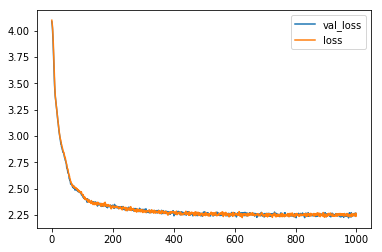

In [139]:
# try:
#   K.clear_session()
#   del model1
# except:
#   pass

model1 = CommVAEBinary( inVecDim, encDim, h_dim=[32,16], n0=0.1*inVecDim, obj_fn='AWGN' ) # in_dim=None, latent_dim=None, h_dim=None, obj_fn = 'RBF', n0=1.0
h = model1.fit( xTrain, epochs=noOfEpochs, batch_size=mbSize, validation_data=(xVal,None), verbose=0 )
for (l,d) in h.items():
  plt.plot(d, label=l )
plt.legend()

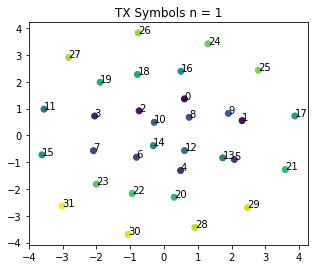

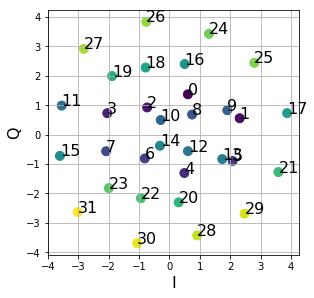

In [140]:
model1.analysis()

m2_points = model1.get_constellation()
# m2_pow = np.mean(np.sum(m2_points*m2_points,axis=1))
# m2_points = np.sqrt(1.0/m2_pow) * m2_points

chDim = m2.latent_dim//2
f = plt.figure(figsize=(3*1.5,3*1.5))
for i in range(chDim):
  ax1 = plt.subplot(1,chDim,i+1)
  ax1.scatter(m2_points[:,i], m2_points[:,i+chDim], c=np.arange(2**model1.in_dim), s=80)
  for j in range(2**model1.in_dim):
    ax1.annotate( j, (m2_points[j,i],m2_points[j,i+chDim]), size=16)
#     # trick to avoid overlap during cheating
#     ax1.annotate( "{:2d}".format(j) if j < 16 else "  {:2d}".format(j), (m2_points[j,i],m2_points[j,i+chDim]), size=16)
plt.grid()
plt.xticks(np.arange(-4.0,4.1,1.0))
plt.yticks(np.arange(-4.0,4.1,1.0))
plt.xlabel("I", fontdict={'fontsize':16})
plt.ylabel("Q", fontdict={'fontsize':16})
# plt.savefig("gray_const_temp.pdf".format(blkSize,chDim), format='pdf', bbox_inches='tight')
# plt.savefig("gray_const_temp.eps".format(blkSize,chDim), format='eps', bbox_inches='tight')
# print(m2_points)

# print(cdist(m2_points,m2_points))

In [118]:
model1.save_model( "model_32symbols_gray_awgn_s050")

Load pretrained models

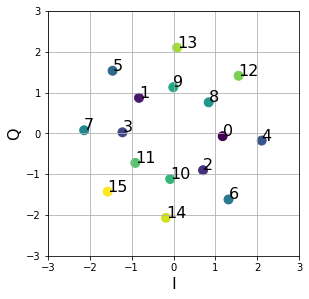

In [64]:
m2 = CommVAEBinary()
m2.load_model("./models_16x01/model_16symbols_gray_rbf")
m2_points = m2.get_constellation()
# m2_pow = np.mean(np.sum(m2_points*m2_points,axis=1))
# m2_points = np.sqrt(1.0/m2_pow) * m2_points

chDim = m2.latent_dim//2
f = plt.figure(figsize=(3*1.5,3*1.5))
for i in range(chDim):
  ax1 = plt.subplot(1,chDim,i+1)
  ax1.scatter(m2_points[:,i], m2_points[:,i+chDim], c=np.arange(2**m2.in_dim), s=80)
  for j in range(2**m2.in_dim):
    ax1.annotate( j, (m2_points[j,i],m2_points[j,i+chDim]), size=16)
plt.grid()
plt.xticks(np.arange(-3.0,3.1,1.0))
plt.yticks(np.arange(-3.0,3.1,1.0))
plt.xlabel("I", fontdict={'fontsize':16})
plt.ylabel("Q", fontdict={'fontsize':16})
plt.savefig("gray_const1.pdf".format(blkSize,chDim), format='pdf', bbox_inches='tight')
plt.savefig("gray_const1.eps".format(blkSize,chDim), format='eps', bbox_inches='tight')

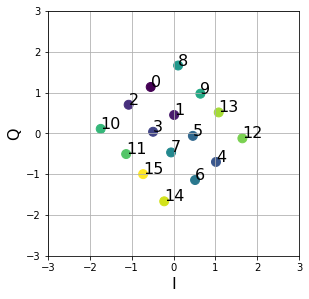

In [63]:
m3 = CommVAEBinary()
m3.load_model("./models_16x01/model_16symbols_gray_awgn_grid")
m3_points = m3.get_constellation()

# m3_pow = np.mean(np.sum(m3_points*m3_points,axis=1))
# m3_points = np.sqrt(1.0/m3_pow) * m3_points

chDim = m3.latent_dim//2
f = plt.figure(figsize=(3*1.5,3*1.5))
for i in range(chDim):
  ax1 = plt.subplot(1,chDim,i+1)
  ax1.scatter(m3_points[:,i], m3_points[:,i+chDim], c=np.arange(2**m2.in_dim), s=80)
  for j in range(2**m3.in_dim):
    ax1.annotate( j, (m3_points[j,i],m3_points[j,i+chDim]), size=16)
plt.grid()
plt.xlabel("I", fontdict={'fontsize':16})
plt.ylabel("Q", fontdict={'fontsize':16})
plt.xticks(np.arange(-3.0,3.1,1.0))
plt.yticks(np.arange(-3.0,3.1,1.0))
plt.savefig("gray_const2.pdf".format(blkSize,chDim), format='pdf', bbox_inches='tight')
plt.savefig("gray_const2.eps".format(blkSize,chDim), format='eps', bbox_inches='tight')

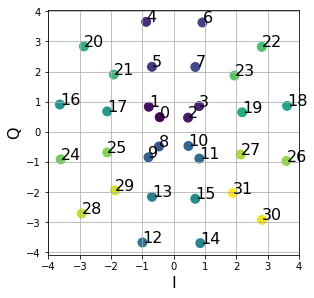

In [143]:
m4 = CommVAEBinary()
m4.load_model("./models_32x01/model_32symbols_gray_awgn_s050")
m4_points = m4.get_constellation()

chDim = m4.latent_dim//2
f = plt.figure(figsize=(3*1.5,3*1.5))
for i in range(chDim):
  ax1 = plt.subplot(1,chDim,i+1)
  ax1.scatter(m4_points[:,i], m4_points[:,i+chDim], c=np.arange(2**m4.in_dim), s=80)
  for j in range(2**m4.in_dim):
    ax1.annotate( j, (m4_points[j,i],m4_points[j,i+chDim]), size=16)
plt.grid()
plt.xlabel("I", fontdict={'fontsize':16})
plt.ylabel("Q", fontdict={'fontsize':16})
plt.xticks(np.arange(-4.0,4.1,1.0))
plt.yticks(np.arange(-4.0,4.1,1.0))
plt.savefig("gray_const_32.pdf".format(blkSize,chDim), format='pdf', bbox_inches='tight')
plt.savefig("gray_const_32.eps".format(blkSize,chDim), format='eps', bbox_inches='tight')

## Train settings for 1-hot encoding

In [86]:
noOfEpochs = 500
blkSize = 2
mbSize = 1000
chDim = 1

# Input
inVecDim   = 2 ** blkSize  # 1-hot vector length for block
encDim = 2*chDim
print( "In Vector Dim:", inVecDim )
print( "z dim:", encDim )

# Train Data
xTrain = np.eye(inVecDim)[np.random.randint(inVecDim,size=10000)]
xVal = np.eye(inVecDim)[np.random.randint(inVecDim,size=10000)]

In Vector Dim: 4
z dim: 2


In [87]:
# try:
#   K.clear_session()
#   del modelAE
# except:
#   pass

modelAE1 = AEOshea1hot(inVecDim, encDim, h_dim=[64,32,16], train_snr_dB=10.0)
h = modelAE1.fit( xTrain, epochs=noOfEpochs, batch_size=mbSize, validation_data=(xVal,None), verbose=0)

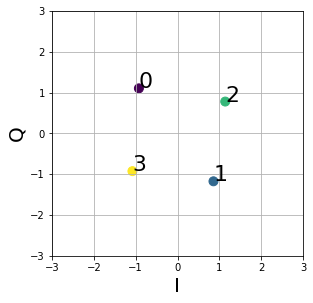

In [88]:
ae_points = modelAE1.get_constellation()

# m3_pow = np.mean(np.sum(m3_points*m3_points,axis=1))
# m3_points = np.sqrt(1.0/m3_pow) * m3_points

chDim = modelAE1.latent_dim//2
f = plt.figure(figsize=(3*1.5,3*1.5))
for i in range(chDim):
  ax1 = plt.subplot(1,chDim,i+1)
  ax1.scatter(ae_points[:,i], ae_points[:,i+chDim], c=np.arange(modelAE1.in_dim), s=80)
  for j in range(modelAE1.in_dim):
    ax1.annotate( j, (ae_points[j,i],ae_points[j,i+chDim]), size=22)
plt.grid()
plt.xlabel("I", fontdict={'fontsize':20})
plt.ylabel("Q", fontdict={'fontsize':20})
plt.xticks(np.arange(-3.0,3.1,1.0))
plt.yticks(np.arange(-3.0,3.1,1.0))
plt.savefig("ae_const.pdf".format(blkSize,chDim), format='pdf', bbox_inches='tight')
plt.savefig("ae_const.eps".format(blkSize,chDim), format='eps', bbox_inches='tight')